# LEDNet
Instalación de la librería fast.ai (a continuación reiniciar el entorno de ejecución).

In [ ]:
!pip install fastai --upgrade

In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from fastai.learner import defaults, Learner

from pathlib import Path
import random

Descarga de la librería de arquitecturas.

In [ ]:
!wget https://www.dropbox.com/s/cmoblvx5icdifwl/architectures.zip?dl=1 -O architectures.zip
!unzip architectures.zip

Descarga del dataset.

In [ ]:
!wget https://www.dropbox.com/s/p92cw15pleunmqe/dataset.zip?dl=1 -O dataset.zip
!unzip dataset.zip

Conexión con Drive para el almacenaje de los modelos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Rutas a los directorios del dataset.

In [5]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"
test_name = "test"

Función que dada la ruta de una imagen devuelve el path de su anotación.

In [6]:
def get_y_fn (x):
    return Path(str(x).replace("Images","Labels"))

Clases: Background y Stoma.

In [7]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

Función que permite partir el dataset entre entrenamiento y test.

In [8]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

# Data augmentation
Carga de la librería Albumentations.

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    HorizontalFlip,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): 
        self.aug = aug
        
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

Transformación que aplica a las imagenes giros horizontales, rotaciones y una operación de distorsión.

In [10]:
transforms=Compose([HorizontalFlip(p=0.5),
                    Flip(p=0.5),
                    Rotate(p=0.40,limit=10)
                    ],p=1)

In [11]:
transformPipeline=SegmentationAlbumentationsTransform(transforms)

Transformación que no aplica cambios a las imagenes.

In [12]:
transforms2=Compose([],p=1)

In [13]:
transform2Pipeline=SegmentationAlbumentationsTransform(transforms2)

Transformación que cambia todos los píxeles con valor 255 a valor 1 en las máscaras.

In [14]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        mask[mask!=255]=0
        # Change 255 for 1
        mask[mask==255]=1
        
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

# Dataloaders
DataBlock de entrenamiento con aumento de datos.

In [15]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de entrenamiento sin aumento de datos.

In [16]:
train2DB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transform2Pipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de test.

In [17]:
testDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

Creación de los dataloaders.

In [18]:
bs = 2
trainDLS = trainDB.dataloaders(path_images,bs=bs)
train2DLS = trainDB.dataloaders(path_images,bs=bs)
testDLS = testDB.dataloaders(path_images,bs=bs)

Prueba de la carga de datos.

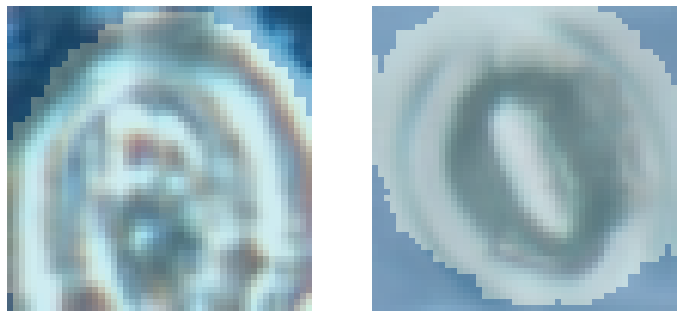

In [19]:
trainDLS.show_batch(vmin=0,vmax=1,figsize=(12, 9))

# Modelos con aumento de datos
Definición del modelo.

In [20]:
from architectures import LEDNet
model = LEDNet(nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [21]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/LEDNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

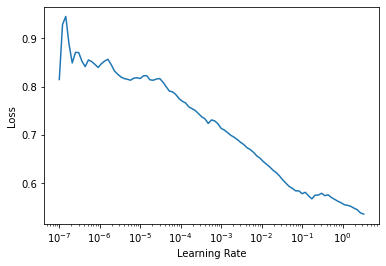

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.443531,0.489349,0.877435,0.781634,08:38
1,0.374696,0.379120,0.903130,0.823369,08:36
2,0.365018,0.354501,0.908932,0.833066,08:39
3,0.328277,0.342720,0.907258,0.830257,08:38
4,0.330413,0.365735,0.908980,0.833147,08:38
5,0.301403,0.729279,0.881425,0.787990,08:37


Better model found at epoch 0 with valid_loss value: 0.4893489480018616.


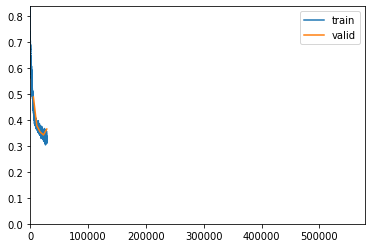

Better model found at epoch 1 with valid_loss value: 0.37912046909332275.
Better model found at epoch 2 with valid_loss value: 0.35450127720832825.
Better model found at epoch 3 with valid_loss value: 0.3427197337150574.
No improvement since epoch 3: early stopping


In [ ]:
name = "model_LEDNet_da_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_LEDNet_da_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.3427197337150574,0.9072575507882393,0.8302574421289123]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

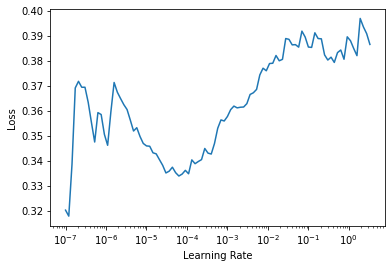

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

Better model found at epoch 1 with valid_loss value: 0.4376142621040344.
Better model found at epoch 2 with valid_loss value: 0.322045236825943.


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.328953,0.450975,0.886491,0.796124,08:36
1,0.322436,0.437614,0.892894,0.806511,08:36
2,0.310798,0.322045,0.918276,0.848900,08:36
3,0.301605,0.723033,0.886600,0.796300,08:30
4,0.287414,0.372671,0.913403,0.840610,08:29


No improvement since epoch 2: early stopping


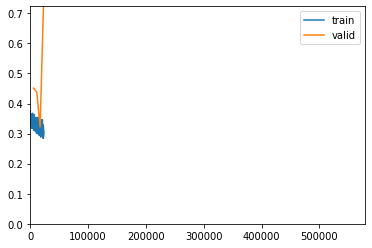

In [ ]:
name = "model_LEDNet_da_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_LEDNet_da_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.322045236825943,0.9182760170014037,0.8489004879561732]



---


Definición del modelo.

In [ ]:
del model, learn
model = LEDNet(nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/LEDNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

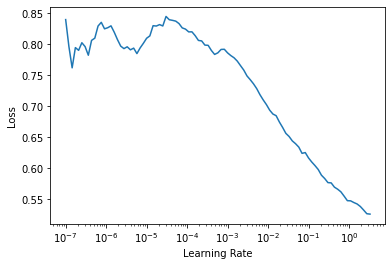

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.428231,0.857008,0.880888,0.787131,08:45
1,0.396771,0.490337,0.891838,0.804790,08:44
2,0.356260,0.420781,0.900722,0.819377,08:40
3,0.340450,0.438445,0.898280,0.815343,08:48
4,0.315622,0.348227,0.906949,0.829740,08:40
5,0.316251,0.790006,0.890306,0.802298,08:41
6,0.292639,0.389321,0.917507,0.847587,08:37


Better model found at epoch 0 with valid_loss value: 0.8570077419281006.


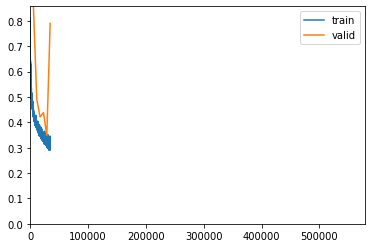

Better model found at epoch 1 with valid_loss value: 0.4903367757797241.
Better model found at epoch 2 with valid_loss value: 0.42078104615211487.
Better model found at epoch 4 with valid_loss value: 0.34822672605514526.
No improvement since epoch 4: early stopping


In [ ]:
name = "model_LEDNet_da_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_LEDNet_da_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.34822672605514526,0.9069485835849975,0.8297400927026961]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

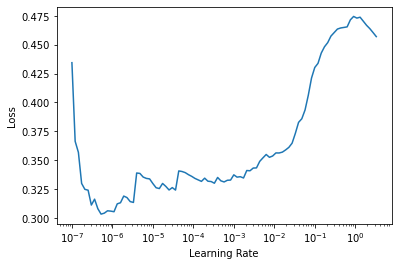

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.315321,0.442852,0.891563,0.804342,08:37
1,0.301847,0.394355,0.908700,0.832676,08:38
2,0.300181,0.470660,0.909502,0.834024,08:43
3,0.300220,0.434678,0.912848,0.839669,08:47


Better model found at epoch 0 with valid_loss value: 0.44285231828689575.


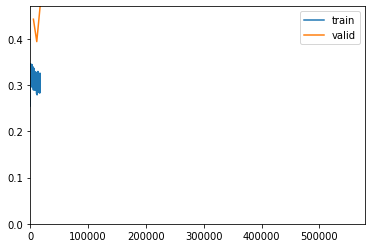

Better model found at epoch 1 with valid_loss value: 0.39435505867004395.
No improvement since epoch 1: early stopping


In [ ]:
name = "model_LEDNet_da_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_LEDNet_da_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.39435505867004395,0.9086997470760961,0.8326761994615424]

# Modelos sin aumento de datos
Definición del modelo.

In [ ]:
del model, learn
model = LEDNet(nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/LEDNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

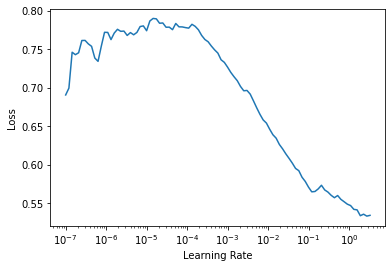

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.409814,0.493646,0.896363,0.812190,09:03
1,0.376836,0.439664,0.907253,0.830250,09:03
2,0.354034,0.374731,0.909721,0.834393,08:53
3,0.354515,0.380486,0.909279,0.833650,08:55
4,0.318318,0.454774,0.914138,0.841855,08:50


Better model found at epoch 0 with valid_loss value: 0.4936455488204956.


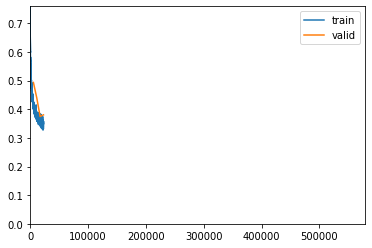

Better model found at epoch 1 with valid_loss value: 0.4396640360355377.
Better model found at epoch 2 with valid_loss value: 0.3747314512729645.
No improvement since epoch 2: early stopping


In [ ]:
name = "model_LEDNet_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_LEDNet_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.3747314512729645,0.9097208894464756,0.834392662063037]

Unfreeze y elección de la tasa de aprendizaje.

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Recorder

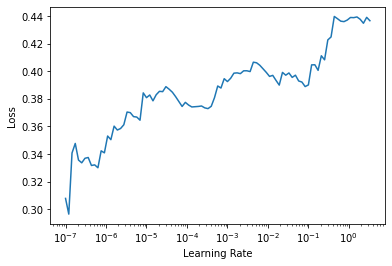

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.353530,0.358566,0.909894,0.834684,08:51
1,0.338487,0.379330,0.911524,0.837431,08:52
2,0.344059,0.381804,0.913617,0.840971,08:52


Better model found at epoch 0 with valid_loss value: 0.3585658371448517.


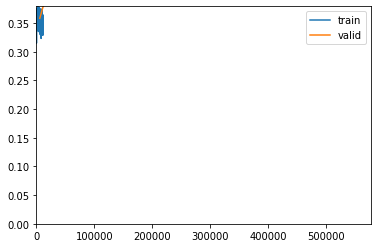

No improvement since epoch 0: early stopping


In [ ]:
name = "model_LEDNet_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_LEDNet_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.3585658371448517,0.9098941880509579,0.8346842830093009]



---


Definición del modelo.

In [22]:
del model, learn
model = LEDNet(nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [23]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/LEDNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

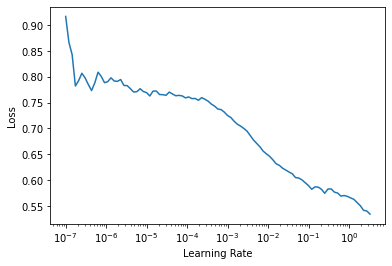

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.432584,0.467163,0.860281,0.754819,08:54
1,0.383964,0.396917,0.888454,0.799296,08:53
2,0.375896,0.367318,0.903499,0.823984,08:55
3,0.349841,0.372189,0.906647,0.829236,08:53
4,0.335763,0.462205,0.904150,0.825067,09:11


Better model found at epoch 0 with valid_loss value: 0.4671632945537567.


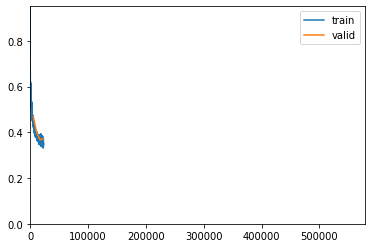

Better model found at epoch 1 with valid_loss value: 0.3969166874885559.
Better model found at epoch 2 with valid_loss value: 0.36731770634651184.
No improvement since epoch 2: early stopping


In [ ]:
name = "model_LEDNet_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_LEDNet_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.36731770634651184,0.9034991609730528,0.8239840124288759]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

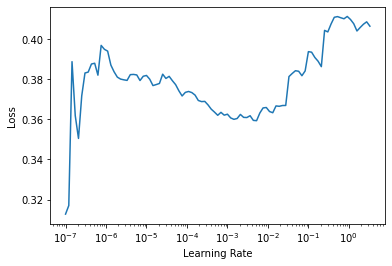

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.358557,0.356764,0.907153,0.830082,09:06
1,0.353424,0.351435,0.907823,0.831204,09:09
2,0.341345,0.338077,0.911910,0.838082,09:03
3,0.326602,0.354502,0.910860,0.836312,09:01
4,0.306834,0.376830,0.914466,0.842411,09:00


Better model found at epoch 0 with valid_loss value: 0.35676437616348267.


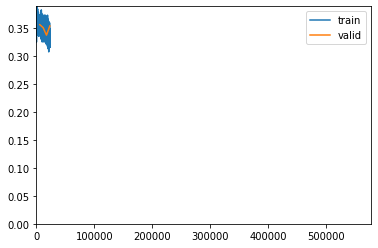

Better model found at epoch 1 with valid_loss value: 0.35143476724624634.
Better model found at epoch 2 with valid_loss value: 0.3380774259567261.
No improvement since epoch 2: early stopping


In [ ]:
name = "model_LEDNet_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_LEDNet_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.3380774259567261,0.911909525707068,0.8380824455793984]

# Evaluación de resultados
## Modelos con aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_LEDNet_da_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.33536040782928467,0.9098629186392294,0.834631657060493]

Comparación de resultado buscado contra resultado obtenido.

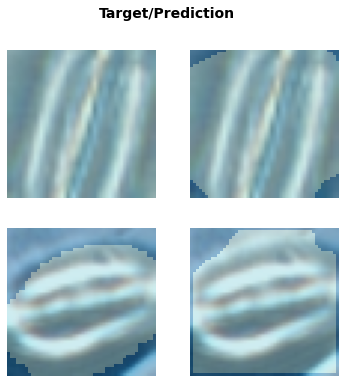

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_LEDNet_da_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.3137502670288086,0.9205555071050193,0.8528048576505918]

Comparación de resultado buscado contra resultado obtenido.

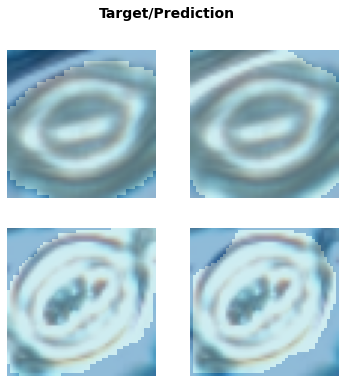

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_LEDNet_da_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.3414626717567444,0.9084038828314727,0.8321794742067845]

Comparación de resultado buscado contra resultado obtenido.

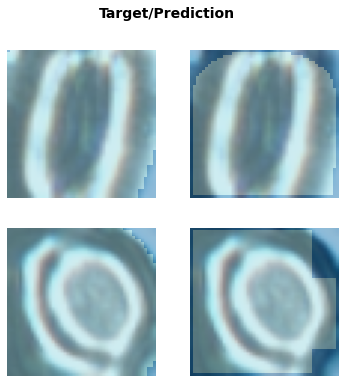

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_LEDNet_da_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.37774354219436646,0.9098058190247579,0.8345355670591487]

Comparación de resultado buscado contra resultado obtenido.

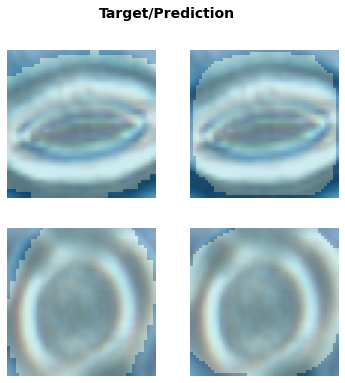

In [ ]:
learn.show_results(vmin=0,vmax=1)

## Modelos sin aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_LEDNet_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.36324548721313477,0.9118576810839344,0.8379948700021757]

Comparación de resultado buscado contra resultado obtenido.

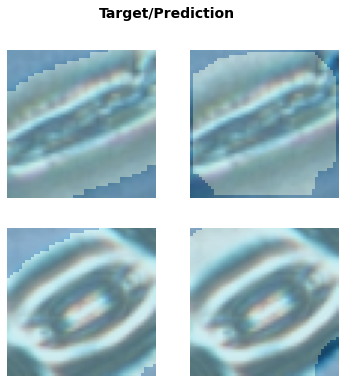

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_LEDNet_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.35013413429260254,0.9122498735584822,0.8386575660927112]

Comparación de resultado buscado contra resultado obtenido.

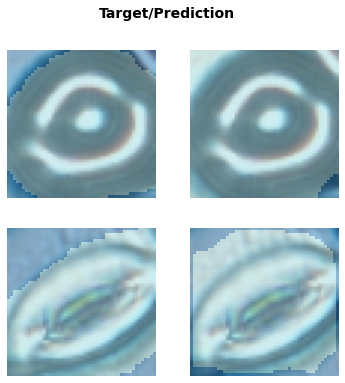

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_LEDNet_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.3591306805610657,0.9047363459222703,0.8260443433449879]

Comparación de resultado buscado contra resultado obtenido.

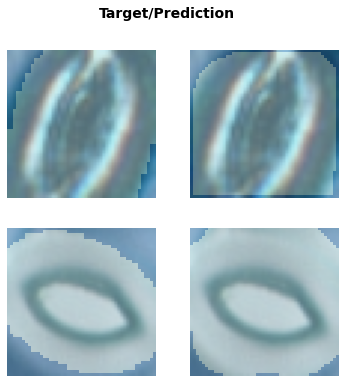

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_LEDNet_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.32746830582618713,0.9139819875060516,0.8415900813718268]

Comparación de resultado buscado contra resultado obtenido.

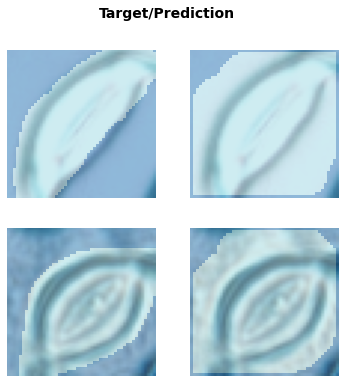

In [ ]:
learn.show_results(vmin=0,vmax=1)

# Exportación del mejor modelo
Carga del modelo en la CPU.

In [24]:
learn.load("model_LEDNet_wd1_unfreeze")
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.32746803760528564,0.9139819875060516,0.8415900813718268]

In [25]:
aux=learn.model
aux=aux.cpu()

Exportación del modelo mediante torch.jit.trace.

In [26]:
import torchvision.transforms as transforms
img = PILImage.create(path_images/'train/1D2_0.png')
transformer=transforms.Compose([transforms.Resize((50,50)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("/content/drive/MyDrive/Colab Notebooks/LEDNet/model_LEDNet.pkl")